In [ ]:
!pip install mlflow --quiet
!pip install pyngrok --quiet

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O
import os
import numpy as np
import pandas as pd
from sklearn import datasets
import seaborn as sns
from sklearn.feature_selection import RFE
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn import linear_model
from sklearn.preprocessing import LabelEncoder
from pandas import get_dummies
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix,mean_squared_error,r2_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import xgboost as xgb


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
train_url ='https://docs.google.com/spreadsheets/d/1UkEkwFQUK3lyk8gVKGnEx4TGKZHecrkX/edit?usp=sharing&ouid=105159144628668759646&rtpof=true&sd=true' 
url2='https://drive.google.com/uc?id=' + train_url.split('/')[-2]
df = pd.read_excel(url2)

In [ ]:
import mlflow

with mlflow.start_run(run_name="MLflow on Colab"):
  mlflow.log_metric("m1", 2.0)
  mlflow.log_param("p1", "mlflow-colab")

# run tracking UI in the background
get_ipython().system_raw("mlflow ui --port 5000 &") # run tracking UI in the background


# create remote tunnel using ngrok.com to allow local port access
# borrowed from https://colab.research.google.com/github/alfozan/MLflow-GBRT-demo/blob/master/MLflow-GBRT-demo.ipynb#scrollTo=4h3bKHMYUIG6

from pyngrok import ngrok

# Terminate open tunnels if exist
ngrok.kill()

# Setting the authtoken (optional)
# Get your authtoken from https://dashboard.ngrok.com/auth
NGROK_AUTH_TOKEN = "224GtSsk6fJBzMAJmKBdpK3b8PN_2usGg659SFcxakfSKDjbb"
ngrok.set_auth_token(NGROK_AUTH_TOKEN)

# Open an HTTPs tunnel on port 5000 for http://localhost:5000
ngrok_tunnel = ngrok.connect(addr="5000", proto="http", bind_tls=True)
print("MLflow Tracking UI:", ngrok_tunnel.public_url)

MLflow Tracking UI: https://1f7e-35-193-46-31.ngrok.io


In [ ]:
def report(df):
    col = []
    d_type = []
    uniques = []
    n_uniques = []
    
    for i in df.columns:
        col.append(i)
        d_type.append(df[i].dtypes)
        uniques.append(df[i].unique()[:5])
        n_uniques.append(df[i].nunique())
    
    return pd.DataFrame({'Column': col, 'd_type': d_type, 'unique_sample': uniques, 'n_uniques': n_uniques})

In [ ]:
report(df)

,Column,d_type,unique_sample,n_uniques
0,CustomerID,object,"[3668-QPYBK, 9237-HQITU, 9305-CDSKC, 7892-POOK...",7043
1,Count,int64,[1],1
2,Country,object,[United States],1
3,State,object,[California],1
4,City,object,"[Los Angeles, Beverly Hills, Huntington Park, ...",1129
5,Zip Code,int64,"[90003, 90005, 90006, 90010, 90015]",1652
6,Lat Long,object,"[33.964131, -118.272783, 34.059281, -118.30742...",1652
7,Latitude,float64,"[33.964131, 34.059281, 34.048013, 34.062125, 3...",1652
8,Longitude,float64,"[-118.272783, -118.30742, -118.293953, -118.31...",1651
9,Gender,object,"[Male, Female]",2


In [ ]:
df_model = df.copy()


In [ ]:
targetVariableName = 'Churn Label'

In [ ]:
summary_df = report(df_model)
one_hot_cols = summary_df[summary_df['d_type']=='object']['Column']
summary_df

,Column,d_type,unique_sample,n_uniques
0,CustomerID,object,"[3668-QPYBK, 9237-HQITU, 9305-CDSKC, 7892-POOK...",7043
1,Count,int64,[1],1
2,Country,object,[United States],1
3,State,object,[California],1
4,City,object,"[Los Angeles, Beverly Hills, Huntington Park, ...",1129
5,Zip Code,int64,"[90003, 90005, 90006, 90010, 90015]",1652
6,Lat Long,object,"[33.964131, -118.272783, 34.059281, -118.30742...",1652
7,Latitude,float64,"[33.964131, 34.059281, 34.048013, 34.062125, 3...",1652
8,Longitude,float64,"[-118.272783, -118.30742, -118.293953, -118.31...",1651
9,Gender,object,"[Male, Female]",2


In [ ]:
#Dropping Country columns as it has only one value type - United States. Also only California state is present
print(df_model['Country'].value_counts())
del df_model['Country']
del df_model['State']
del df_model['CustomerID']
del df_model['City']
del df_model['Zip Code']


#Dropping Count columns as it has only one value type - 1
print(df_model['Count'].value_counts())
del df_model['Count']

#Also deleting latitute and longitutes as it has no purpose and other target related variable
for items in ['Lat Long', 'Latitude','Longitude','Churn Score', 'CLTV', 'Churn Reason']:
#for items in ['Lat Long','Churn Score', 'CLTV', 'Churn Reason']:
    del df_model[items]

United States    7043
Name: Country, dtype: int64
1    7043
Name: Count, dtype: int64


In [ ]:
print(df_model.isna().sum())
df_model.replace(r'^\s*$', np.nan, regex=True, inplace=True)
df_model.isna().sum()

Gender               0
Senior Citizen       0
Partner              0
Dependents           0
Tenure Months        0
Phone Service        0
Multiple Lines       0
Internet Service     0
Online Security      0
Online Backup        0
Device Protection    0
Tech Support         0
Streaming TV         0
Streaming Movies     0
Contract             0
Paperless Billing    0
Payment Method       0
Monthly Charges      0
Total Charges        0
Churn Label          0
Churn Value          0
dtype: int64


Gender                0
Senior Citizen        0
Partner               0
Dependents            0
Tenure Months         0
Phone Service         0
Multiple Lines        0
Internet Service      0
Online Security       0
Online Backup         0
Device Protection     0
Tech Support          0
Streaming TV          0
Streaming Movies      0
Contract              0
Paperless Billing     0
Payment Method        0
Monthly Charges       0
Total Charges        11
Churn Label           0
Churn Value           0
dtype: int64

In [ ]:
import math
def imputeTotalCharges(df):
  for index, row in df.iterrows():
    if(math.isnan(row['Total Charges'])):
      df.at[index, 'Total Charges'] = df.at[index, 'Monthly Charges'] * df.at[index, 'Tenure Months']
      #row['Total Charges'] = row['Monthly Charges'] * row['Tenure Months']
  return df
df_model = imputeTotalCharges(df_model)

In [ ]:
df_1 = df_model.copy()

In [ ]:
import plotly.express as px
fig = px.pie(df_1['Churn Label'].value_counts().reset_index().rename(columns={'index':'Type'}), color_discrete_sequence=px.colors.sequential.Teal, values='Churn Label', names='Type', width=400, height=400)
fig.update_traces(textfont_size=18, textposition='inside',textinfo='percent+label')
fig.update_layout(title_text='Churn Distribution', title_x=0.5,title_y=0.9, showlegend=False)
fig.show()

In [ ]:
fig = px.pie(df_1['Payment Method'].value_counts().reset_index().rename(columns={'index':'Type'}), color_discrete_sequence=px.colors.sequential.Teal, values='Payment Method', names='Type', title='Payment Method Distribution')
fig.update_traces(textposition='inside')
fig.show()

In [ ]:
#Defining bar chart function
def bar(feature, df=df_1 ):
    #Groupby the categorical feature
    temp_df = df.groupby([feature, 'Churn_Value']).size().reset_index()
    temp_df = temp_df.rename(columns={0:'Count'})
    #Calculate the value counts of each distribution and it's corresponding Percentages
    value_counts_df = df[feature].value_counts().to_frame().reset_index()
    categories = [cat[1][0] for cat in value_counts_df.iterrows()]
    #Calculate the value counts of each distribution and it's corresponding Percentages
    num_list = [num[1][1] for num in value_counts_df.iterrows()]
    div_list = [element / sum(num_list) for element in num_list]
    percentage = [round(element * 100,1) for element in div_list]
    #Defining string formatting for graph annotation
    #Numeric section
    def num_format(list_instance):
        formatted_str = ''
        for index,num in enumerate(list_instance):
            if index < len(list_instance)-2:
                formatted_str=formatted_str+f'{num}%, ' #append to empty string(formatted_str)
            elif index == len(list_instance)-2:
                formatted_str=formatted_str+f'{num}% & '
            else:
                formatted_str=formatted_str+f'{num}%'
        return formatted_str
    #Categorical section
    def str_format(list_instance):
        formatted_str = ''
        for index, cat in enumerate(list_instance):
            if index < len(list_instance)-2:
                formatted_str=formatted_str+f'{cat}, '
            elif index == len(list_instance)-2:
                formatted_str=formatted_str+f'{cat} & '
            else:
                formatted_str=formatted_str+f'{cat}'
        return formatted_str
    

    #Running the formatting functions
    num_str = num_format(percentage)
    cat_str = str_format(categories)
    #Setting graph framework
    fig = px.bar(temp_df, x=feature, y='Count', color='Churn_Value', title=f'Churn rate by {feature}', barmode="group",color_continuous_scale = "mint")
    fig.add_annotation(
                text=f'Value count of distribution of {cat_str} are<br>{num_str} percentage respectively.',
                align='left',
                showarrow=False,
                xref='paper',
                yref='paper',
                x=1.2,
                y=1.2,
                bordercolor='black',
                borderwidth=1)
    fig.update_layout(
        # margin space for the annotations on the right
        margin=dict(r=400),
    )
     
    return fig.show()

In [ ]:
all_columns = [column.replace(" ", "_").replace("(", "_").replace(")", "_").replace("-", "_") for column in df_1.columns]
df_1.columns = all_columns
df_1

,Gender,Senior_Citizen,Partner,Dependents,Tenure_Months,Phone_Service,Multiple_Lines,Internet_Service,Online_Security,Online_Backup,Device_Protection,Tech_Support,Streaming_TV,Streaming_Movies,Contract,Paperless_Billing,Payment_Method,Monthly_Charges,Total_Charges,Churn_Label,Churn_Value
0,Male,No,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,1
1,Female,No,No,Yes,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,1
2,Female,No,No,Yes,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.50,Yes,1
3,Female,No,Yes,Yes,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes,1
4,Male,No,No,Yes,49,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30,Yes,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,Female,No,No,No,72,Yes,No,No,No internet service,No internet service,No internet service,No internet service,No internet service,No internet service,Two year,Yes,Bank transfer (automatic),21.15,1419.40,No,0
7039,Male,No,Yes,Yes,24,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.50,No,0
7040,Female,No,Yes,Yes,72,Yes,Yes,Fiber optic,No,Yes,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.90,No,0
7041,Female,No,Yes,Yes,11,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No,0


In [ ]:
#Gender feature plot
bar('Gender')
#SeniorCitizen feature plot 
bar('Senior_Citizen')
 #convert 1 to Yes in all data instances#bar('Senior_Citizen')
#Partner feature plot
bar('Partner')
#Dependents feature plot
bar('Dependents')

In [ ]:
bar('Phone_Service')
bar('Multiple_Lines')
bar('Internet_Service')

In [ ]:
bar('Online_Security')
bar('Online_Backup')
bar('Device_Protection')

In [ ]:
bar('Tech_Support')
bar('Streaming_TV')
bar('Streaming_Movies')

In [ ]:
bar("Contract")
bar("Paperless_Billing")

In [ ]:
df_2 = df_model.copy()
codes = {'Male':0, 'Female':1}
df_2['Gender'] = df_2['Gender'].map(codes)

codes = {'No':0, 'Yes':1}
for items in ['Senior Citizen', 'Partner','Dependents','Phone Service','Paperless Billing']:
	df_2[items] = df_2[items].map(codes)

codes = {'No':0, 'Yes':1,'No phone service':2}
df_2['Multiple Lines'] = df_2['Multiple Lines'].map(codes)

codes = {'DSL':0, 'Fiber optic':1,'No':2}
df_2['Internet Service'] = df_2['Internet Service'].map(codes)

codes = {'Yes':0, 'No':1,'No internet service':2}
for items in ['Online Security','Online Backup','Device Protection','Tech Support','Streaming TV','Streaming Movies']:
	df_2[items] = df_2[items].map(codes)

codes = {'Month-to-month':0, 'Two year':1,'One year':2}
df_2['Contract'] = df_2['Contract'].map(codes)

codes = {'Mailed check':0, 'Electronic check':1,'Bank transfer (automatic)':2,'Credit card (automatic)':3}
df_2['Payment Method'] = df_2['Payment Method'].map(codes)

In [ ]:
import statsmodels.api as sm


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning:

pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.



In [ ]:
df_model.columns
x_ols_features = ['Gender', 'Senior Citizen', 'Partner', 'Dependents', 'Tenure Months',
       'Phone Service', 'Multiple Lines', 'Internet Service',
       'Online Security', 'Online Backup', 'Device Protection', 'Tech Support',
       'Streaming TV', 'Streaming Movies', 'Contract', 'Paperless Billing',
       'Payment Method', 'Monthly Charges', 'Total Charges']
y_ols = df_2["Churn Value"]


In [ ]:
def get_stats():
    x_ols = df_2[x_ols_features]
    results = sm.OLS(y_ols, x_ols.astype(float)).fit()
    results_summary = results.summary()
    #print(results_summary)
    results_as_html = results_summary.tables[1].as_html()
    result_sum = pd.read_html(results_as_html, header=0, index_col=0)[0]
    p_val = result_sum['P>|t|']
    if max(p_val) <= 0.05 : 
        return x_ols_features , p_val, False
    #st.header('Column to be removed is',p_val.idxmax())
    print("*******************")
    print("Droping " + p_val.idxmax())
    x_ols_features.remove(p_val.idxmax())    
    return x_ols_features, p_val, True

In [ ]:
con = True
while(con):
  x_ols_features, p_val, con = get_stats()

*******************
Droping Multiple Lines
*******************
Droping Streaming TV
*******************
Droping Gender
*******************
Droping Streaming Movies


In [ ]:
df_model = df_model[x_ols_features]
df_model.head()

,Senior Citizen,Partner,Dependents,Tenure Months,Phone Service,Internet Service,Online Security,Online Backup,Device Protection,Tech Support,Contract,Paperless Billing,Payment Method,Monthly Charges,Total Charges
0,No,No,No,2,Yes,DSL,Yes,Yes,No,No,Month-to-month,Yes,Mailed check,53.85,108.15
1,No,No,Yes,2,Yes,Fiber optic,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65
2,No,No,Yes,8,Yes,Fiber optic,No,No,Yes,No,Month-to-month,Yes,Electronic check,99.65,820.50
3,No,Yes,Yes,28,Yes,Fiber optic,No,No,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05
4,No,No,Yes,49,Yes,Fiber optic,No,Yes,Yes,No,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.30


In [ ]:
from sklearn.preprocessing import OneHotEncoder
cat_columns = [cname for cname in df_model.columns if df_model[cname].dtype == "object"]

encoder=OneHotEncoder(sparse=False)
train_X_encoded = pd.DataFrame (encoder.fit_transform(df_model[cat_columns]))
train_X_encoded.columns = encoder.get_feature_names(cat_columns)

df_model.drop(cat_columns ,axis=1, inplace=True)

df_model2= pd.concat([df_model, train_X_encoded ], axis=1)
df_model2[targetVariableName] = y_ols

# We need 'categorical' type for categorical columns for lightgbm
#for col in df_model.columns:
#    if col in cat_columns:
#        df_model[col] = df_model[col].astype('category')

#df_model2 = pd.get_dummies(df_model, columns = cat_columns)
number=LabelEncoder()
df_model2[targetVariableName]=number.fit_transform(df_model2[targetVariableName])


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


In [ ]:
import pickle
with open("encoder", "wb") as f: 
    pickle.dump(encoder, f)

In [ ]:
X = df_model2.drop('Churn Label', axis=1)
y = df_model2['Churn Label']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [ ]:
import multiprocessing
import time
n_cpus = multiprocessing.cpu_count()
n_cpus

2

In [ ]:
def evaluation(model, x_train, y_train, x_test, y_test):

    pred = model.predict(x_test)
    
    '''
    classifier_report = pd.DataFrame(classification_report(y_test, pred, output_dict = True))
    print("Test Result:\n================================================")
    print(f"Accuracy Score: {accuracy_score(y_test, pred) * 100:.2f}%")
    print("_______________________________________________")
    print(f"F1 Score: {round(f1_score(y_test, pred, average=avgMethod), 5)}")
    print("_______________________________________________")
    print(f"CLASSIFICATION REPORT:\n{classifier_report}")
    print("_______________________________________________")
    '''
    print(f"Confusion Matrix: \n {confusion_matrix(y_test, pred)}\n")
    
    return round(f1_score(y_test, pred,average='weighted'), 5)

def lrModelWithParameterTuning(X_train, y_train, X_test, y_test):
    t1= time.time()
    params = {
        "C": [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 1e1, 1e2, 1e3, 1e4], # For Regularization
          "solver": ["liblinear"]}

    lr = LogisticRegression()
    lr_cv = GridSearchCV(lr, params, scoring = "accuracy", n_jobs = n_cpus , verbose = 0, cv = 5)
    lr_cv.fit(X_train, y_train)
    best_params = lr_cv.best_params_

    print(f"Best parameters: {best_params}")
    lr = LogisticRegression(**best_params,class_weight='balanced')
    lr.fit(X_train, y_train)
    lr_f1=evaluation(lr, X_train, y_train, X_test, y_test)
    t2 = time.time()
    print("LR is done with F1 score " + str(lr_f1) + " Time is " + str(t2-t1))

def svmModelWithParameterTuning(X_train, y_train, X_test, y_test):
    t1= time.time()
    params={'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']
           }
    svm = SVC()
    svm_cv= GridSearchCV(svm, params, scoring = "accuracy", n_jobs = n_cpus , verbose = 0, cv = 5)
    svm_cv.fit(X_train, y_train)
    best_params = svm_cv.best_params_
    print(f"Best parameters: {best_params}")
    #best_params = {'C': 1, 'gamma': 0.001, 'kernel': 'rbf'}
    svm=SVC(**best_params)
    svm.fit(X_train, y_train)
    svm_f1=evaluation(svm, X_train, y_train, X_test, y_test)
    t2= time.time()
    print("SVM is done with F1 score " + str(svm_f1)  + " Time is " + str(t2-t1))


def randomForestModelWithParameterTuning(X_train, y_train, X_test, y_test):
    t1= time.time()
    params = { 'n_estimators': [50, 150, 250,350,450],
      'max_features': ['sqrt', 0.25, 0.5, 0.75, 1.0],
      'min_samples_split': [2, 4, 6]
      }

    rfc = RandomForestClassifier()
    rfc_cv = GridSearchCV(rfc, params, scoring = "accuracy", n_jobs = n_cpus , verbose = 0, cv = 5)
    rfc_cv.fit(X_train, y_train)
    best_params = rfc_cv.best_params_
    print(f"Best parameters: {best_params}")
    #best_params = {'max_features': 0.5, 'min_samples_split': 6, 'n_estimators': 250}
    rfc = RandomForestClassifier(**best_params)
    rfc.fit(X_train, y_train)
    rf_f1=evaluation(rfc, X_train, y_train, X_test, y_test)
    t2= time.time()
    print("RandomForest is done with F1 score " + str(rf_f1)  + " Time is " + str(t2-t1))

def knnModelWithParameterTuning(X_train, y_train, X_test, y_test):
    t1= time.time()

    f1 = []

    for i in range(1, 10):
        knn = KNeighborsClassifier(n_neighbors = i)
        knn.fit(X_train, y_train)
        f1.append(f1_score(y_test, knn.predict(X_test)))
    #print(accuracy_scores)
    nVal=f1.index(max(f1))
    print(nVal)
    #print("Trained KNN MODEL")
    #print("Printing Out the model performance")
    knn = KNeighborsClassifier(n_neighbors = nVal+1)
    knn.fit(X_train, y_train)
    print(f1)

    plt.figure(figsize=(12, 8))
    plt.plot(range(1,10), f1, label="Train score")
    # plt.plot(neighbors, test_score, label="Test score")
    plt.xticks(np.arange(1, 10, 1))
    plt.xlabel("Number of Neighbors")
    plt.ylabel("Model Score")
    plt.legend()
    knn_f1=evaluation(knn, X_train, y_train, X_test, y_test)
    t2= time.time()
    print("KNN is done with F1 score " + str(knn_f1)  + " Time is " + str(t2-t1) )

def XGBoostWithParameterTuning(X_train, y_train, X_test, y_test):
    import xgboost as xgb
    t1= time.time()

    xgb_m = xgb.XGBClassifier()
    params = {
    'n_estimators': range(5,10),
    #'n_estimators': [18],
    'max_depth': range(1,5),
    #'max_depth': [1],
    'learning_rate': [.1,.4, .45, .5, .55, .6],
    'colsample_bytree': [.6, .7, .8, .9, 1],
    'booster':["gbtree"],
     'min_child_weight': [0.001,0.003,0.01],
    }
    xgb_cv = GridSearchCV(xgb_m, params, scoring = "accuracy", n_jobs = n_cpus , verbose = 0, cv = 5)
    xgb_cv.fit(X_train, y_train)
    best_params = xgb_cv.best_params_
    print(f"Best parameters: {best_params}")    
    xgb_m=xgb.XGBClassifier(**best_params)   
    xgb_m.fit(X_train, y_train)
    xgb_f1=evaluation(xgb_m, X_train, y_train, X_test, y_test)
    t2= time.time()

    print("XGBoost is done with F1 score " + str(xgb_f1)  + " Time is " + str(t2-t1))
  
def lightgbm(X_train, y_train, X_test, y_test):
    import lightgbm
    t1= time.time()

    param_grid = {
              'max_depth': [5,6,7,4, 9,10,12],
              'num_leaves': [4,11, 9,10],
              'learning_rate': [0.1,0.01,0.001,0.2],
              'scale_pos_weight': [3],
              'n_estimators': [50, 100],
              'reg_lambda': [10, 15,20,25],
              'subsample': [0.9],
              'colsample_bytree': [0.5, 0.6]
              }
    lgb = lightgbm.LGBMClassifier(random_state=1)
    #xgb_cv = GridSearchCV(xgb_m, params, scoring = "accuracy", n_jobs = n_cpus , verbose = 0, cv = 5)
    
    opt_params = GridSearchCV(estimator=lgb,
                           param_grid=param_grid,
                           scoring='roc_auc',
                           cv=3)
    
    opt_params.fit(X_train, y_train)
    best_params = opt_params.best_params_
    print(f"Best parameters: {best_params}")    
    #best_params = {'colsample_bytree': 0.5, 'learning_rate': 0.2, 'max_depth': 5, 'n_estimators': 50, 'num_leaves': 4, 'reg_lambda': 15, 'scale_pos_weight': 3, 'subsample': 0.9}
    lgb = lightgbm.LGBMClassifier(**best_params)
    lgb.fit(X_train, y_train)

    lgb_f1=evaluation(lgb, X_train, y_train, X_test, y_test)
    t2= time.time()

    print("lightBoost is done with F1 score " + str(lgb_f1)  + " Time is " + str(t2-t1))

def ensemble(X_train, y_train, X_test, y_test):
    lr = LogisticRegression()
    svm = SVC()
    rfc = RandomForestClassifier()
    xgb_m = xgb.XGBClassifier()
    #lgb = lightgbm.LGBMClassifier()

    from sklearn.ensemble import VotingClassifier
    estimators=[('lr', lr), ('svm', svm), ('rfc', rfc), ('xgb_m', xgb_m)]
    ensemble = VotingClassifier(estimators, voting='hard')
    ensemble.fit(X_train, y_train)

    ensemble_f1=evaluation(ensemble, X_train, y_train, X_test, y_test)


    print("ensemble is done with F1 score " + str(ensemble_f1))



In [ ]:
#lrModelWithParameterTuning(X_train, y_train, X_test, y_test)
#svmModelWithParameterTuning(X_train, y_train, X_test, y_test)

#randomForestModelWithParameterTuning(X_train, y_train, X_test, y_test)
#knnModelWithParameterTuning(X_train, y_train, X_test, y_test)
#XGBoostWithParameterTuning(X_train, y_train, X_test, y_test)
#lightgbm(X_train, y_train, X_test, y_test)
ensemble(X_train, y_train, X_test, y_test)

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


Confusion Matrix: 
 [[980  68]
 [219 142]]

ensemble is done with F1 score 0.77622


In [ ]:
sc = StandardScaler()
X_train_std = X_train.copy()
X_test_std = X_test.copy()

X_train_std[['Tenure Months',	'Monthly Charges',	'Total Charges']] = sc.fit_transform(np.array(X_train_std[['Tenure Months',	'Monthly Charges',	'Total Charges']]))
X_test_std[['Tenure Months',	'Monthly Charges',	'Total Charges']] = sc.fit_transform(np.array(X_test_std[['Tenure Months',	'Monthly Charges',	'Total Charges']]))


In [ ]:
lrModelWithParameterTuning(X_train_std, y_train,X_test_std, y_test)
#if binaryClassification:
#svmModelWithParameterTuning(X_train_std, y_train, X_test_std, y_test)

#randomForestModelWithParameterTuning(X_train_std, y_train, X_test_std, y_test)
#knnModelWithParameterTuning(X_train_std, y_train, X_test_std, y_test)
#XGBoostWithParameterTuning(X_train_std, y_train, X_test_std, y_test)
#lightgbm(X_train_std, y_train, X_test_std, y_test)

Best parameters: {'C': 0.1, 'solver': 'liblinear'}
Confusion Matrix: 
 [[775 273]
 [ 74 287]]

LR is done with F1 score 0.76741 Time is 1.0294578075408936


In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 0)
X_train_std_res, y_train_std_res = sm.fit_resample(X_train_std, y_train.ravel())

Best parameters: {'C': 0.1, 'solver': 'liblinear'}
Confusion Matrix: 
 [[778 270]
 [ 80 281]]

LR is done with F1 score 0.76509 Time is 1.2607622146606445
Best parameters: {'C': 1000, 'gamma': 1, 'kernel': 'linear'}
Confusion Matrix: 
 [[705 343]
 [ 73 288]]

SVM is done with F1 score 0.72311 Time is 10225.312566757202
Best parameters: {'max_features': 0.25, 'min_samples_split': 2, 'n_estimators': 250}
Confusion Matrix: 
 [[887 161]
 [140 221]]

RandomForest is done with F1 score 0.78831 Time is 1110.4383471012115
8
[0.49803407601572736, 0.4679582712369598, 0.5325714285714286, 0.5408805031446541, 0.5570175438596492, 0.5784543325526932, 0.5816649104320337, 0.594413407821229, 0.5995850622406639]
Confusion Matrix: 
 [[734 314]
 [ 72 289]]

KNN is done with F1 score 0.74255 Time is 2.7618281841278076
Best parameters: {'booster': 'gbtree', 'colsample_bytree': 0.7, 'learning_rate': 0.6, 'max_depth': 4, 'min_child_weight': 0.001, 'n_estimators': 8}
Confusion Matrix: 
 [[833 215]
 [ 96 265]]



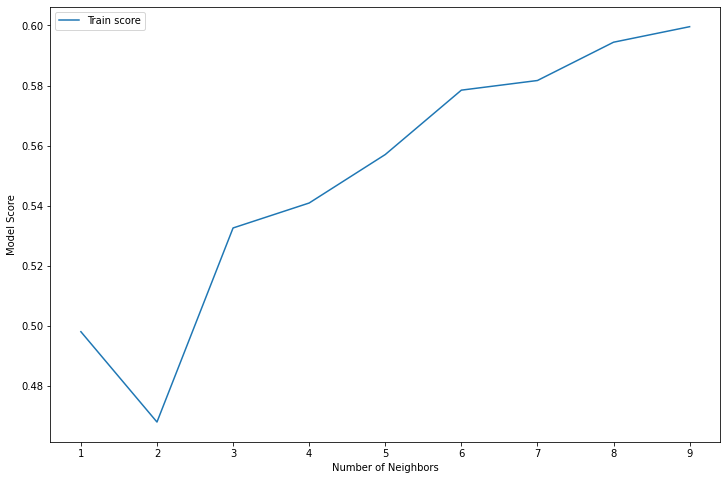

In [ ]:
lrModelWithParameterTuning(X_train_std_res, y_train_std_res,X_test_std, y_test)
#if binaryClassification:
svmModelWithParameterTuning(X_train_std_res, y_train_std_res,X_test_std, y_test)

randomForestModelWithParameterTuning(X_train_std_res, y_train_std_res,X_test_std, y_test)
knnModelWithParameterTuning(X_train_std_res, y_train_std_res,X_test_std, y_test)
XGBoostWithParameterTuning(X_train_std_res, y_train_std_res,X_test_std, y_test)
lightgbm(X_train_std_res, y_train_std_res,X_test_std, y_test)

In [ ]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 0)
X_train_res, y_train_res = sm.fit_resample(X_train, y_train.ravel())

Best parameters: {'C': 0.1, 'solver': 'liblinear'}
Confusion Matrix: 
 [[889 159]
 [135 226]]

LR is done with F1 score 0.79349 Time is 2.913740873336792
Best parameters: {'C': 1000, 'gamma': 0.0001, 'kernel': 'rbf'}
Confusion Matrix: 
 [[851 197]
 [145 216]]

SVM is done with F1 score 0.76234 Time is 468.4800205230713
Best parameters: {'max_features': 'sqrt', 'min_samples_split': 6, 'n_estimators': 350}
Confusion Matrix: 
 [[918 130]
 [161 200]]

RandomForest is done with F1 score 0.79034 Time is 950.784277677536
8
[0.45409429280397023, 0.41185185185185186, 0.48089887640449436, 0.48958333333333337, 0.5083986562150056, 0.5221674876847291, 0.5257393209200438, 0.5172004744958482, 0.5298013245033113]
Confusion Matrix: 
 [[743 305]
 [121 240]]

KNN is done with F1 score 0.71381 Time is 2.4369266033172607
Best parameters: {'booster': 'gbtree', 'colsample_bytree': 0.9, 'learning_rate': 0.5, 'max_depth': 4, 'min_child_weight': 0.001, 'n_estimators': 9}
Confusion Matrix: 
 [[890 158]
 [134 227

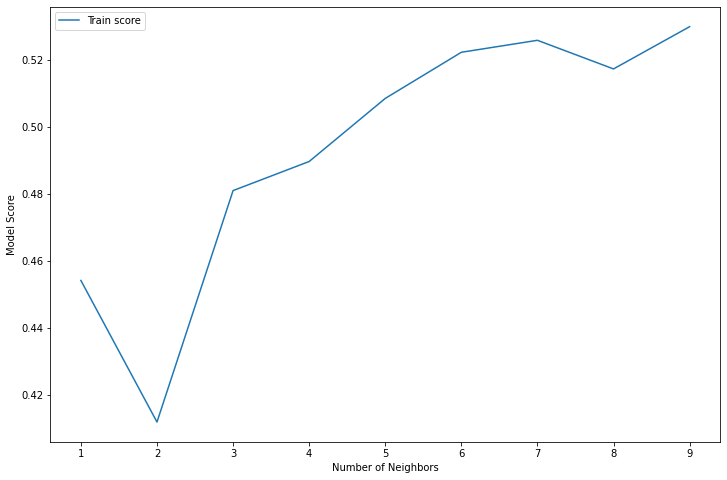

In [ ]:
lrModelWithParameterTuning(X_train_res, y_train_res,X_test, y_test)
#if binaryClassification:
svmModelWithParameterTuning(X_train_res, y_train_res, X_test, y_test)

randomForestModelWithParameterTuning(X_train_res, y_train_res, X_test, y_test)
knnModelWithParameterTuning(X_train_res, y_train_res, X_test, y_test)
XGBoostWithParameterTuning(X_train_res, y_train_res, X_test, y_test)
lightgbm(X_train_res, y_train_res, X_test, y_test)

In [ ]:
from tensorflow.keras import Input,Model
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input,Model
from tensorflow.keras.layers import Dense
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau


In [ ]:

#X_train_std_res, y_train_std_res,X_test_std, y_test

input_layer = Input(shape=(X_train_std_res.shape[1],))
#normLayer = horsepower_normalizer(input_layer)
'''
dense_layer_1 = Dense(1024,activation='relu')(input_layer)
dense_layer_2 = Dense(1024,activation='relu')(dense_layer_1)
dense_layer_3 = Dense(1024,activation='relu')(dense_layer_2)
dense_layer_4 = Dense(512,activation='relu')(dense_layer_3)
dense_layer_5 = Dense(256,activation='relu')(dense_layer_4)
dense_layer_6 = Dense(256,activation='relu')(dense_layer_5)
'''
dense_layer_1 = Dense(128,activation='relu')(input_layer)
dense_layer_2 = Dense(64,activation='relu')(dense_layer_1)
dense_layer_3 = Dense(32,activation='relu')(dense_layer_2)
output_layer = Dense(1,activation='sigmoid')(dense_layer_3)
model_1 = Model(inputs=input_layer,outputs=output_layer)

model_1.summary()
model_1.compile(loss = tf.keras.losses.binary_crossentropy,
              optimizer = tf.keras.optimizers.Adam(lr=0.001),
              #optimizer = "SGD",
              metrics = ['accuracy'])

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.3, verbose=1,patience=10, min_lr=0.0000000001)
early_stopping_cb = EarlyStopping(patience=10, restore_best_weights=True)


history_1 = model_1.fit(X_train_std_res, y_train_std_res,epochs=50,validation_split = 0.2, callbacks=[early_stopping_cb, reduce_lr])


y_pred = model_1.predict(X_test_std)
y_pred

y_pred = [1 if x > 0.5 else 0 for x in y_pred ]
#y_pred_2 = pd.Series(y_pred_2.reshape(1,y_pred.shape[0])[0])
y_pred = pd.Series(y_pred)
#y_pred = pd.Series(y_pred.reshape(1,y_pred.shape[0])[0])
y_pred = y_pred.astype(int)

from sklearn.metrics import confusion_matrix
print(confusion_matrix(y_test, y_pred))
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix,mean_squared_error,r2_score
print(f"F1 Score: {round(f1_score(y_test, y_pred, average='weighted'), 5)}")
classifier_report = pd.DataFrame(classification_report(y_test, y_pred, output_dict = True))
print(f"CLASSIFICATION REPORT:\n{classifier_report}")

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 46)]              0         
                                                                 
 dense_25 (Dense)            (None, 128)               6016      
                                                                 
 dense_26 (Dense)            (None, 64)                8256      
                                                                 
 dense_27 (Dense)            (None, 32)                2080      
                                                                 
 dense_28 (Dense)            (None, 1)                 33        
                                                                 
Total params: 16,385
Trainable params: 16,385
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


207/207 [==============================] - 2s 6ms/step - loss: 0.4625 - accuracy: 0.7720 - val_loss: 0.4556 - val_accuracy: 0.8092 - lr: 0.0010
Epoch 2/50
207/207 [==============================] - 1s 5ms/step - loss: 0.4138 - accuracy: 0.8052 - val_loss: 0.4116 - val_accuracy: 0.8225 - lr: 0.0010
Epoch 3/50
207/207 [==============================] - 1s 5ms/step - loss: 0.4003 - accuracy: 0.8140 - val_loss: 0.4514 - val_accuracy: 0.8237 - lr: 0.0010
Epoch 4/50
207/207 [==============================] - 1s 5ms/step - loss: 0.3887 - accuracy: 0.8181 - val_loss: 0.4334 - val_accuracy: 0.8068 - lr: 0.0010
Epoch 5/50
207/207 [==============================] - 1s 4ms/step - loss: 0.3791 - accuracy: 0.8258 - val_loss: 0.3913 - val_accuracy: 0.8413 - lr: 0.0010
Epoch 6/50
207/207 [==============================] - 1s 4ms/step - loss: 0.3754 - accuracy: 0.8232 - val_loss: 0.4718 - val_accuracy: 0.7947 - lr: 0.0010
Epoch 7/50
207/207 [==============================] - 1s 4ms/step - loss: 0.3679 

In [ ]:
# Plot the validation and training data separately
def plot_loss_curves(history):
  """
  Returns separate loss curves for training and validation metrics.
  """ 
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # Plot loss
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # Plot accuracy
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

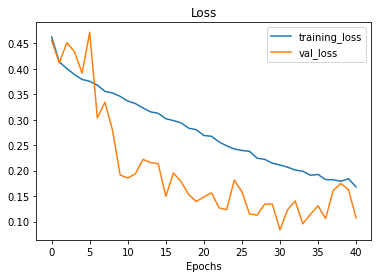

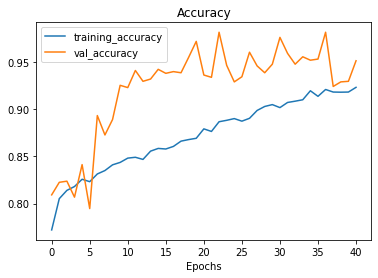

In [ ]:
plot_loss_curves(history_1)